# IA353 - Redes Neurais
# EFC3 - Questão 5

## Autoencoder training and manifold visualization
## Partially based on https://www.kaggle.com/apapiu/manifold-learning-and-autoencoders

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Rafael Ito

### 5.1. Imports

In [1]:
import tensorflow as tf
import os
from multiprocessing import cpu_count

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input, Conv2D, UpSampling2D, Reshape, Deconvolution2D, Conv2DTranspose, BatchNormalization
from keras.optimizers import adam
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
# version
tf.__version__

'2.2.0'

In [3]:
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# choose between CPU and GPU
device = tf.device('/cpu:0')
if tf.config.list_physical_devices('GPU'):
    device = tf.device('/device:GPU:0')
#    device_model = torch.cuda.get_device_name(0)
#    device_memory = torch.cuda.get_device_properties(device).total_memory / 1e9
    device_number = len(tf.config.experimental.list_physical_devices('GPU'))
    #----------------------------
    #from tensorflow.python.client import device_lib
    #print(device_lib.list_local_devices())
    #----------------------------
    print('Device: gpu')
    #print('GPU model:', device_model)
    #print('GPU memory: {0:.2f} GB'.format(device_memory))
    print("GPUs available: ", device_number)
    print('#-------------------')
print('CPU cores:', cpu_count())

### 5.2. Reading the data

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
x_images = x_train.reshape(x_train.shape[0], 28, 28)

In [8]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

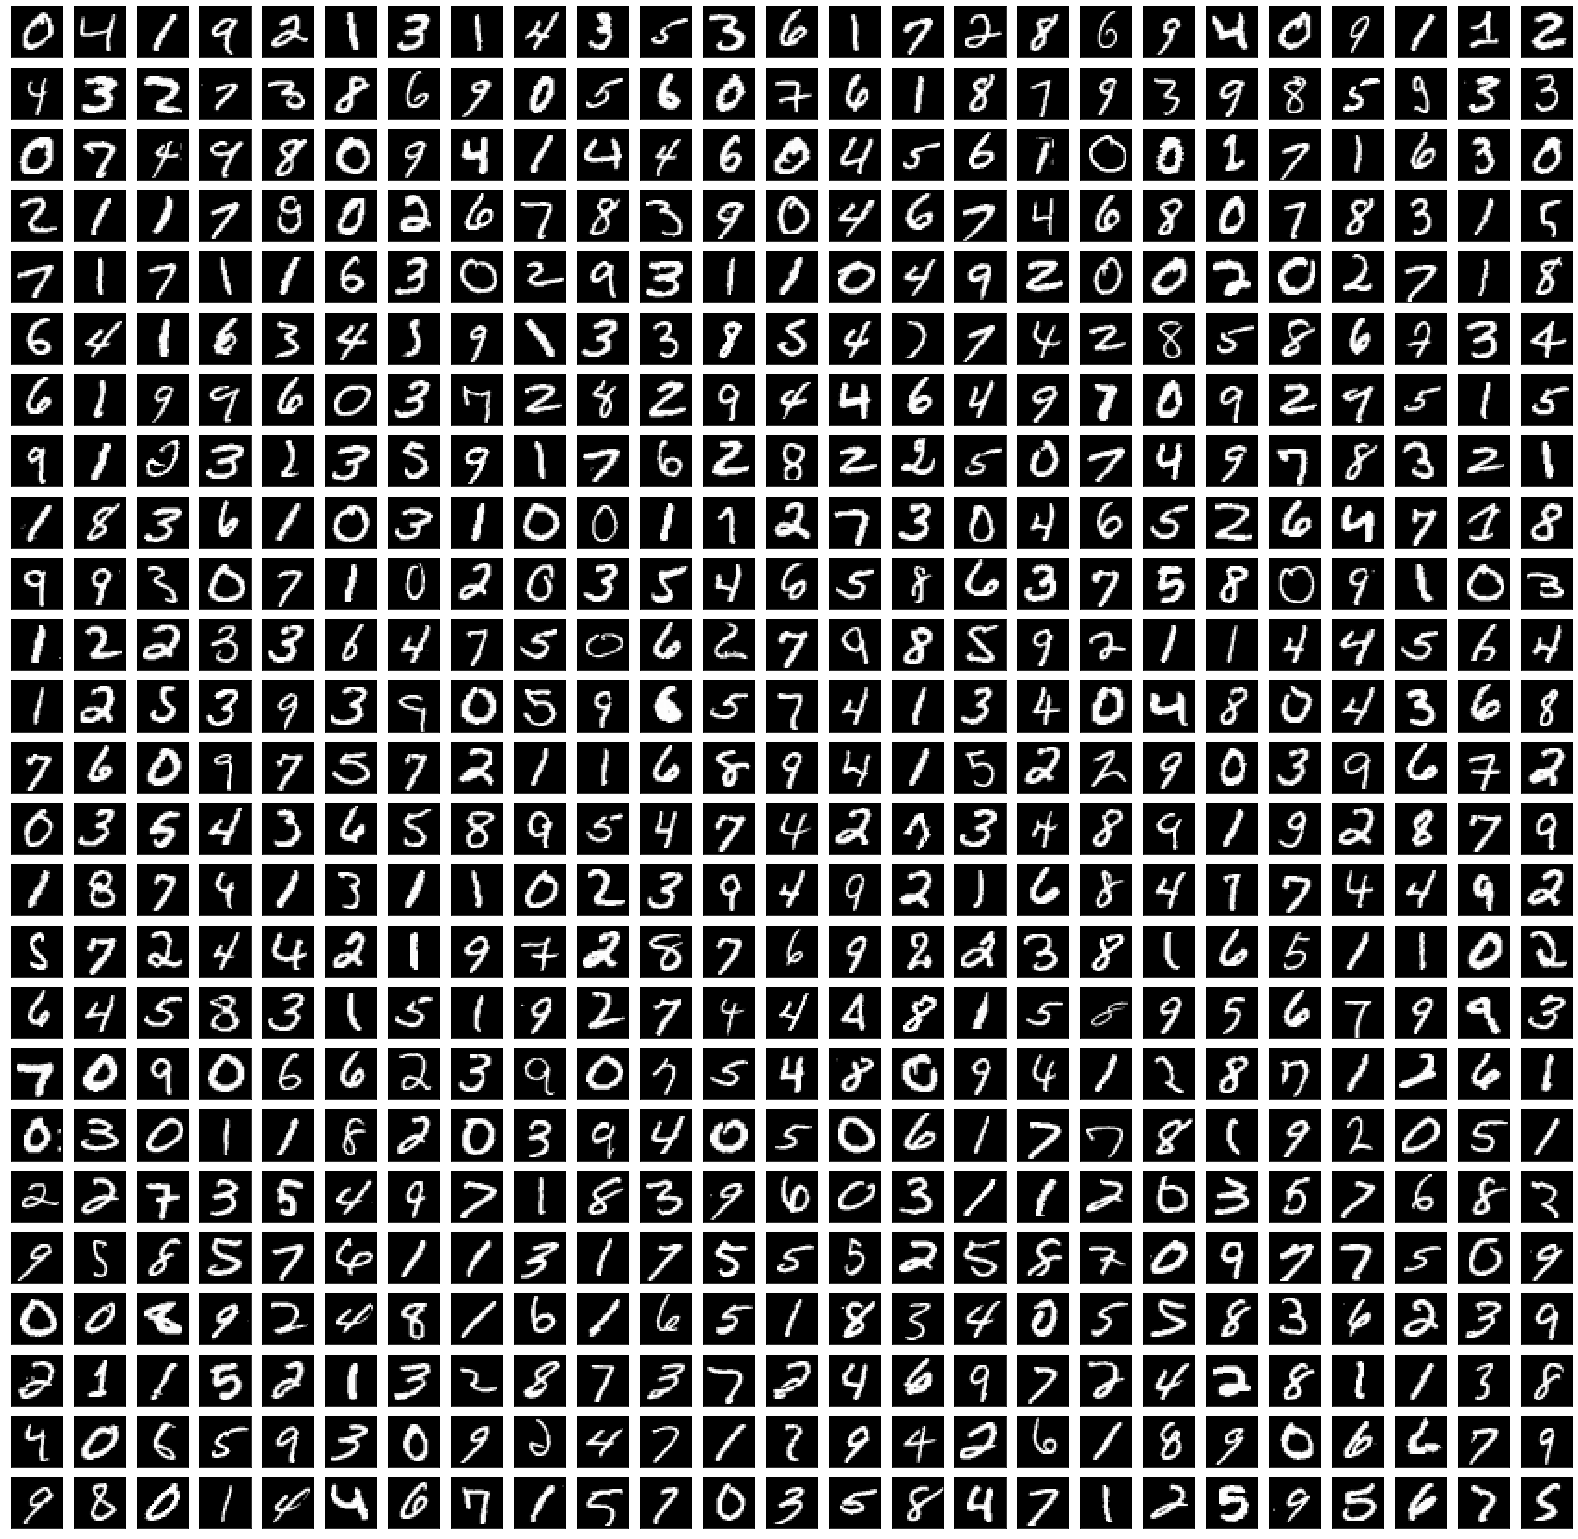

In [9]:
# Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### 5.3 Proposal for the autoencoder architecture

In [10]:
input_img = Input(shape=(784,))
#==========================================================
reshape = Reshape((28,28,1))(input_img)
encoded = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(reshape)             # (60000,14,14,32)
encoded = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(encoded)             # (60000,7,7,64)
encoded = Conv2D(128, (3, 3), activation='relu', strides=2, padding='valid')(encoded)           # (60000,3,3,128)
#-----------------------------
encoded = Flatten()(encoded)                                # (60000,1152)
encoded = Dense(128, activation='tanh')(encoded)            # (60000,128)
encoded = Dense(16, activation='tanh')(encoded)             # (60000,16)
#==========================================================
encoded = Dense(2, activation=None)(encoded)                # (60000,2) --> bottleneck
#==========================================================
decoded = Dense(16, activation='tanh')(encoded)             # (60000,16)
decoded = Dense(128, activation='tanh')(decoded)            # (60000,128)
decoded = Dense(1152, activation='tanh')(decoded)           # (60000,1152)
decoded = Reshape((3, 3, 128))(decoded)                                                         # (60000,3,3,128)
#-----------------------------
decoded = Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='valid')(decoded)    # (60000,7,7,64)
decoded = BatchNormalization()(decoded)
#-----------------------------
decoded = Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(decoded)     # (60000,14,14,32)
decoded = BatchNormalization()(decoded)
#-----------------------------
decoded = Conv2DTranspose(1, (3,3), strides=2, activation='sigmoid', padding='same')(decoded)   # (60000,28,28,1)
decoded = Reshape((784,))(decoded)
#==========================================================
autoencoder = Model(input=input_img, output=decoded)

In [12]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1475

In [14]:
with device:
    autoencoder.compile(optimizer='adam', loss = "mse")
    X = x_train.reshape(x_train.shape[0], 784)
    history = autoencoder.fit(
        X, 
        X, 
        batch_size = 128, 
        nb_epoch = 10, 
        verbose = 1,
    )

Epoch 1/10
60000/60000 [==============================] - 13s 222us/step - loss: 0.0718
Epoch 2/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.0454
Epoch 3/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.0430
Epoch 4/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.0417
Epoch 5/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.0407
Epoch 6/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.0399
Epoch 7/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.0393
Epoch 8/10
60000/60000 [==============================] - 6s 103us/step - loss: 0.0388
Epoch 9/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.0383
Epoch 10/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.0380


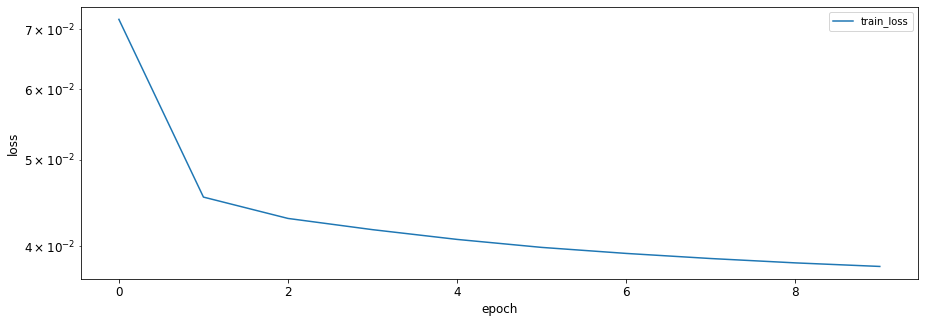

In [15]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

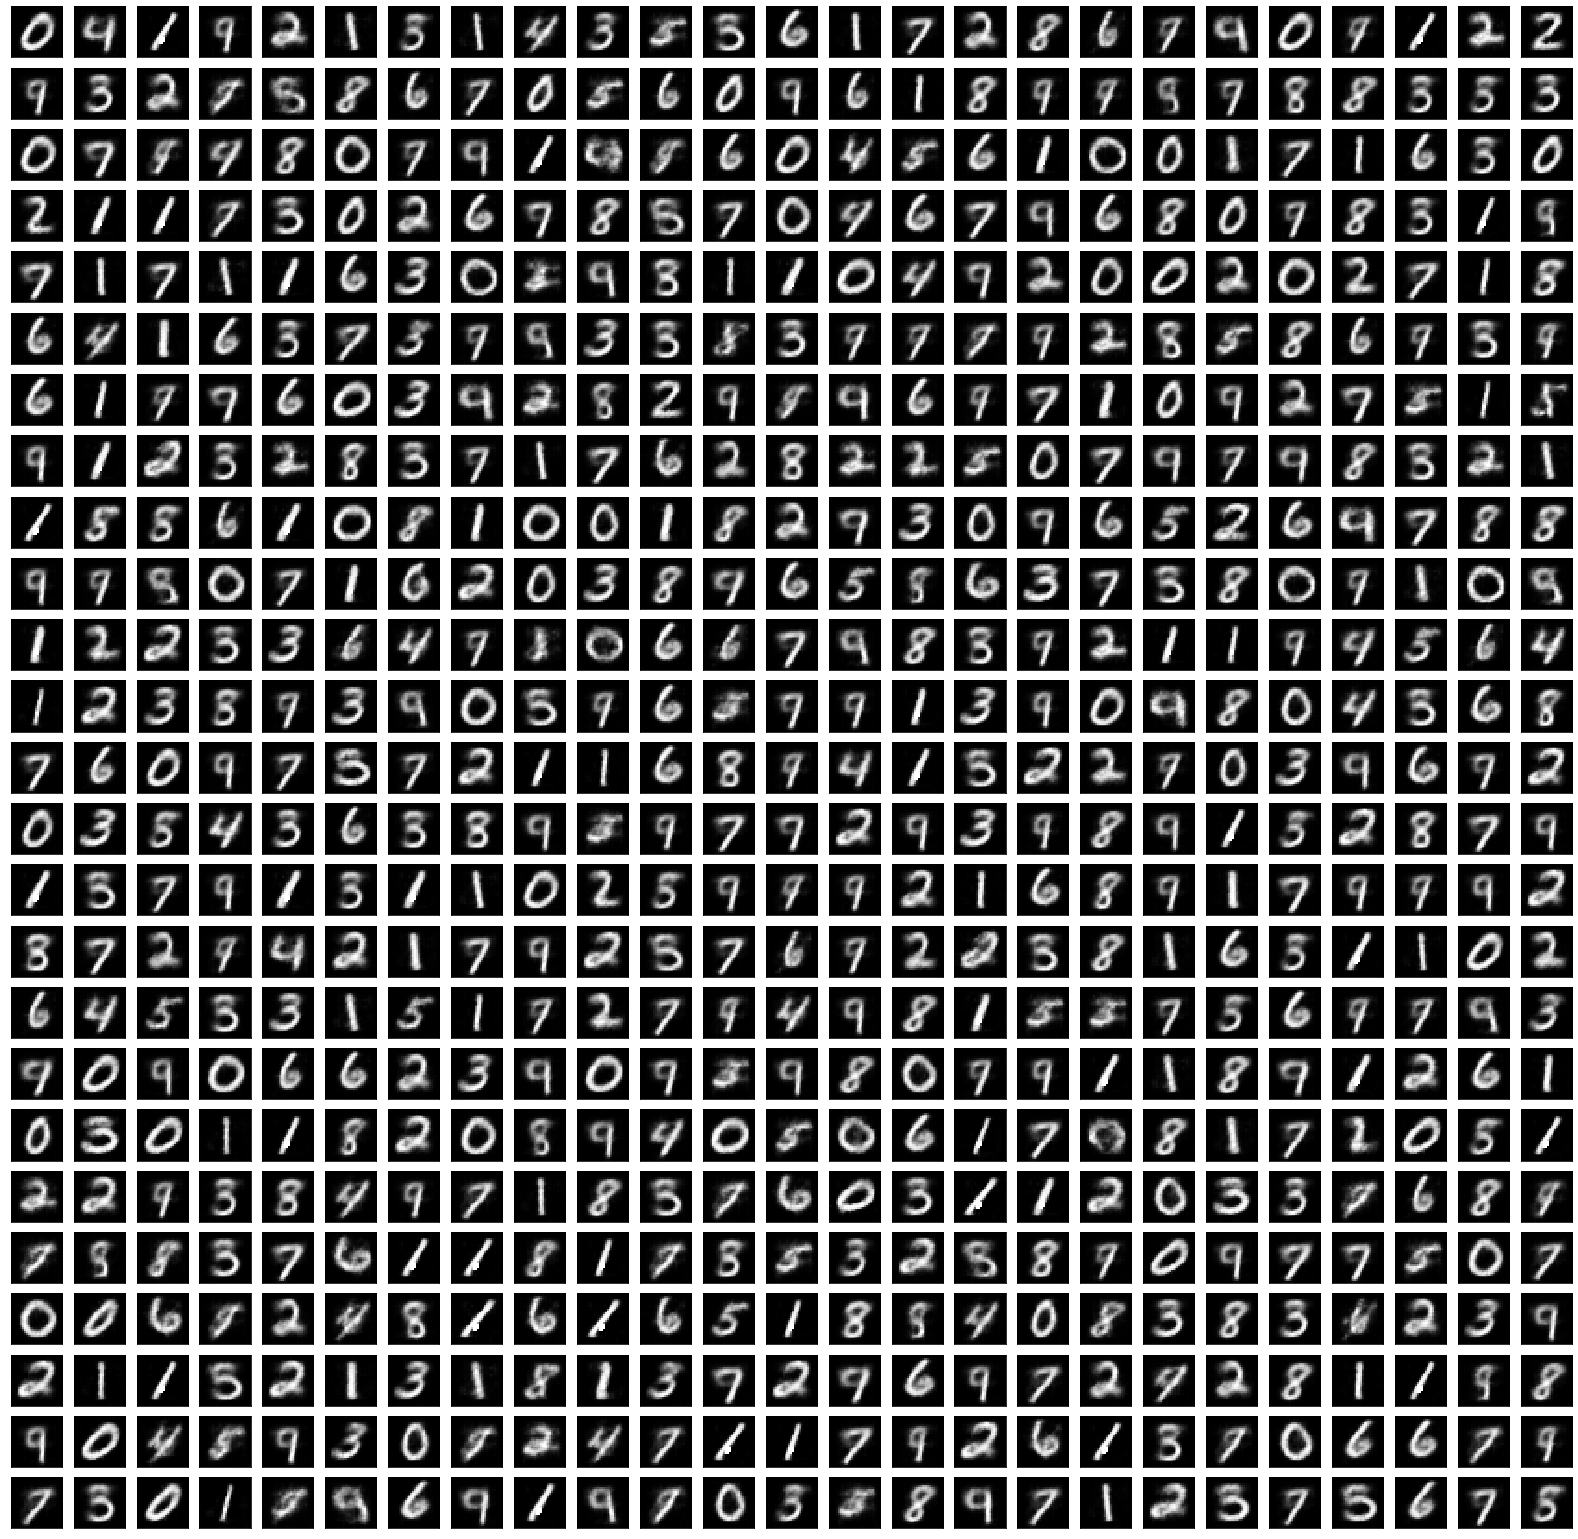

In [16]:
# Visualization of 25 x 25 reconstructed images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(autoencoder.predict(np.expand_dims(x_images[ind].flatten(), 0)).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [18]:
encoder = Model(input = input_img, output = encoded)

# Building the decoder
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-10]
encoded_layer_2 = autoencoder.layers[-9]
encoded_layer_3 = autoencoder.layers[-8]
encoded_layer_4 = autoencoder.layers[-7]
encoded_layer_5 = autoencoder.layers[-6]
encoded_layer_6 = autoencoder.layers[-5]
encoded_layer_7 = autoencoder.layers[-4]
encoded_layer_8 = autoencoder.layers[-3]
encoded_layer_9 = autoencoder.layers[-2]
encoded_layer_10 = autoencoder.layers[-1]
 
decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = encoded_layer_3(decoder)
decoder = encoded_layer_4(decoder)
decoder = encoded_layer_5(decoder)
decoder = encoded_layer_6(decoder)
decoder = encoded_layer_7(decoder)
decoder = encoded_layer_8(decoder)
decoder = encoded_layer_9(decoder)
decoder = encoded_layer_10(decoder)
decoder = Model(input=encoded_input, output=decoder)

### 5.4 Visualizing the mapping of the labeled images in the manifold

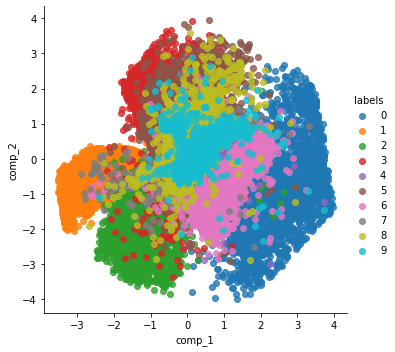

In [19]:
import seaborn as sns

x_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

x_proj = encoder.predict(x_flat[:60000])
x_proj.shape

proj = pd.DataFrame(x_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:60000]
sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)

### 5.5. Generating new digits by moving along the manifold (latent 2D space)
**Please, adjust the scale whenever necessary.**

### 5.5.1 Moving along a circle

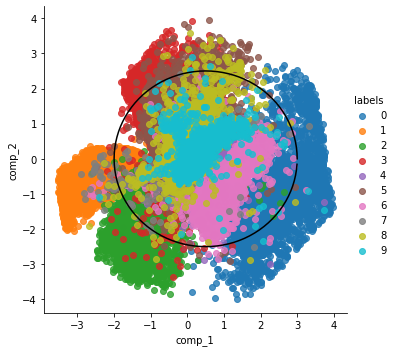

In [38]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [2.5 * np.cos(2 * np.pi / 100 * i) + 0.5 for i in range(100)]
all_y = [2.5 * np.sin(2 * np.pi / 100 * i) + 0 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

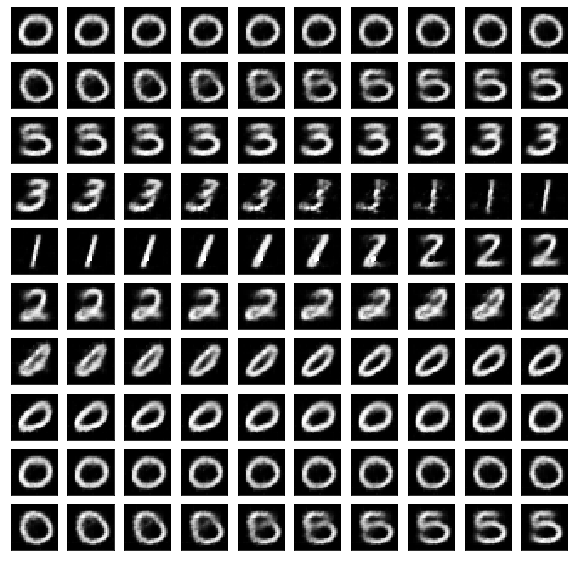

In [39]:
# moving along a circle:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 3 * np.cos(2.5 * np.pi / 100 * i) + 0.5
    y = 3 * np.sin(2.5 * np.pi / 100 * i) + 0
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.2 Moving along an ellipse

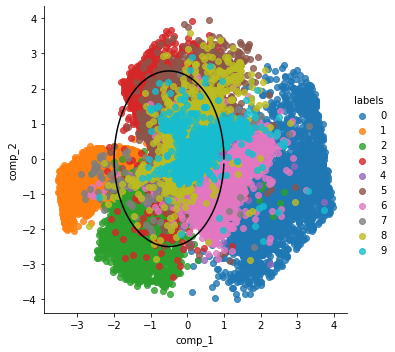

In [42]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [1.5 * np.cos(2 * np.pi / 100 * i) - 0.5 for i in range(100)]
all_y = [2.5 * np.sin(2 * np.pi / 100 * i) - 0 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

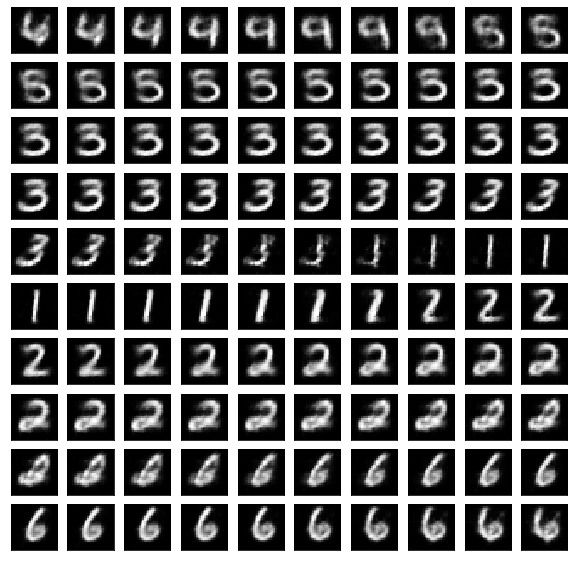

In [43]:
# moving along a elipse:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 1.5 * np.cos(2 * np.pi / 100 * i) - 0.5
    y = 2.5 * np.sin(2 * np.pi / 100 * i) - 0
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.3 Moving along a grid

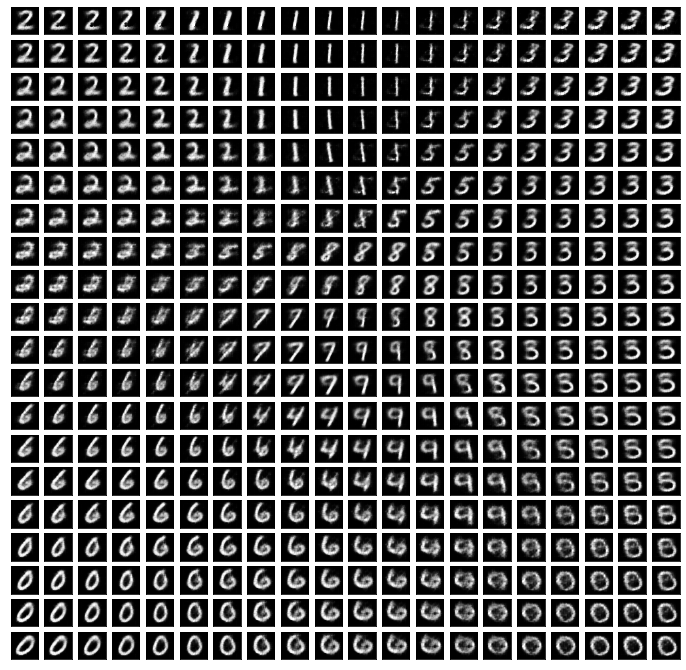

In [45]:
# moving along a elipse:
_ = plt.figure(figsize=(12, 12))

for i in range(20):
    for j in range(20):
        
        _ = plt.subplot(20, 20, i * 20 + j + 1)
        # range adapted to go from -2 to +2 in both X and Y axis
        pt = np.array([[ -2 + 4 * i/19, -2 + 4 * j/19]])
        _ = show(decoder.predict(pt).reshape((28, 28)))
        _ = plt.xticks([])
        _ = plt.yticks([])